# Force Balance System Analysis

This notebook demonstrates the force balance system (FBS) in M2.
There are 3 axial actuators and 3 tangent links are chosen to be hardpoints.
While being the hardpoints, they support the mirror to be fixed at a specific location without any movement in the normal operation (e.g. open-loop or closed-loop control).
In other words, if there is any inactive or broken actuator, it should be selected as a hardpoint to support the telescope survey in the night (the fix will happen in the next day).

The idea of M2 FBS is to compensate the demanded force on hardpoints to other actuators while keeping the consistent moments.
The measured force of hardpoints may or may not be 0, which depends on the mirror's orientation (zenith or horizon).
For example, if the mirror is face-up/down in the ideal orientation and assembly, the force on tangential hardpoints should be 0.

Since FBS relates to the look-up table (LUT), we will discuss LUT first followed by FBS.

## Reference from Vendor

LSST M2 Correctability Analysis by Greg Bogan, May 19, 2016.

## Import Modules

This notebook needs to setup the **ts_m2com** and **ts_aos_utils** under the **notebooks/.user_setups**, which depends on the **ts_tcpip**.
You also need to have **ts_mtm2** under the **WORK/** directory to read the confiugration files to do the analysis.

In [1]:
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import numpy.typing
from astropy.time import Time
from scipy import optimize

from lsst.ts.m2com import (
    MockControlClosedLoop,
    NUM_ACTUATOR,
    NUM_TANGENT_LINK,
    NUM_HARDPOINTS_AXIAL,
)

from lsst.ts.aos.utils import DiagnosticsM2, EfdName

## Declaration of User-Defined Functions

In [2]:
def diff_value_avg(
    x_data: numpy.typing.NDArray[np.float64],
    y_data: numpy.typing.NDArray[np.float64],
    x_ref: numpy.typing.NDArray[np.float64],
    y_ref: numpy.typing.NDArray[np.float64],
) -> float:
    """Average of the difference of values.
    
    Parameters
    ----------
    x_data: `numpy.ndarray`
        Data x.
    y_data: `numpy.ndarray`
        Data y.
    x_ref : `numpy.ndarray`
        Reference x.
    y_ref : `numpy.ndarray`
        Reference y.

    Returns
    -------
    `float`
        Average of the difference.
    """

    y_ref_interp = np.interp(x_data, x_ref, y_ref)
    values = np.sum(np.abs(y_data - y_ref_interp))

    return values / len(x_data)

In [3]:
def fit_moment_z(
    array_x: numpy.typing.NDArray[np.float64],
    angles: numpy.typing.NDArray[np.float64],
    moment: numpy.typing.NDArray[np.float64],
    radius: float,
):
    """Fit the moment z.
    
    Parameters
    ----------
    array_x : `numpy.ndarray`
        Coefficients to fit.
    angles : `numpy.ndarray`
        Angles in degree.
    moment : `numpy.ndarray`
        Moment in N * m.
    radius : `float`
        Radius of mirror in meter.

    Returns
    -------
    `float`
        Difference.
    """
    values = array_x[0] + array_x[1] * radius * np.sin(np.deg2rad(angles - array_x[2]))
    return np.sum(np.abs(values - moment))

## Instantiate the MockControlClosedLoop and Diagonostic Tool

M2 have two different sets of LUT files: one is for the surrogate, and one is for the mirror.
They are used to compensate the gravity and temperature changes.
It is noted that only the axail actuators have the temperature correction at this moment.

Note:

1. When the vendor delivered the hardware, 16 temperature sensors have been installed on the ring.
Recently, we had installed another 6 temperature sensors on tangent links.
Therefore, it is possible to support the temperature correction for tangent links in the future when needed.
2. Since the temperature correction is much smaller than the gravity correction, this notebook will focus on the gravity correction only.

In [4]:
config_path = Path.home() / "WORK" / "ts_mtm2" / "config"

filepath_surrogate = config_path / "parameter_files" / "luts" / "FinalHandlingLUTs"
filepath_mirror = config_path / "parameter_files" / "luts" / "FinalOpticalLUTs"

filepath_cell_geom = config_path / "cellGeom.json"

In [5]:
control_closed_loop_surrogate = MockControlClosedLoop()
control_closed_loop_surrogate.load_file_lut(filepath_surrogate)
control_closed_loop_surrogate.load_file_cell_geometry(filepath_cell_geom)
control_closed_loop_surrogate.set_hardpoint_compensation()

control_closed_loop_mirror = MockControlClosedLoop()
control_closed_loop_mirror.load_file_lut(filepath_mirror)
control_closed_loop_mirror.load_file_cell_geometry(filepath_cell_geom)
control_closed_loop_mirror.set_hardpoint_compensation()

diagnostics_m2 = DiagnosticsM2(efd_name=EfdName.Usdf)
xy_actuators = diagnostics_m2.get_xy_actuators(control_closed_loop_surrogate)

hardpoints = [5, 15, 25, 73, 75, 77]

## LUT Difference between Surrogate and Mirror

There are 4 components for gravity and temperature corrections individually:

1. **F_E**: Force for the elevation component of command in Newton.
2. **F_0**: Force for the 0g component of command in Newton.
3. **F_A**: Force for the actuator force bias in Newton.
4. **F_F**: Force for the factory force offset in Newton.
5. **Tr**: Temperature compensation vector for radial gradient.
6. **Tx**: Temperature compensation vector for x-gradient.
7. **Ty**: Temperature compensation vector for y-gradient.
8. **Tu**: Temperature compensation vector for uniform gradient.

All components are **independent** with each other.

Between the surrogate and mirror, the only difference of LUT is **F_F**.
For the surrogate, all values in **F_F** LUT are 0.
Compared with the gravity correction, the temperature correction is very small.
Therefore, its affection in FBS is very limited.

In the LUT calculation, the LUT angle should have the same coordinate system as telescope mount assembly (TMA) at 0-90 degree.
This has been verified at level 3 with the cart rotation, and we would need to verify this again after putting the M2 on TMA.

## Elevation Component

**F_E** is interpolated from the stored LUT:

1. Linear interpolation between closest two elevations in table.
2. Without **F_0**, **F_E** is the bare elevation LUT equal to the minimum strain forces.
3. Nominally, 5 degree increments from 90 (zenith) to -265 degrees.
90-0 is telescope operating range.
0-(-265) is for cart turnove0-(-265) is for cart turnover.

Based on the reference 1, two LUT interpolation approaches were already investigated:

1. Polynomial curve fitting to generate a function of elevation angle.
2. Linear interpolation.

Both methods generated similar force error (relative to a smoothed curve) on the order of 0.1 pounds for 5 degree table increment.
Error is less than the load cell accuracy requirement of +/-0.225 pounds.
Polynomial curve fitting would significantly increase the complexity of LUT updating.
Therefore, the elevation-dependent forces will be calculated by linear interpolation because it is accurate and simple in the LabVIEW cell control system.

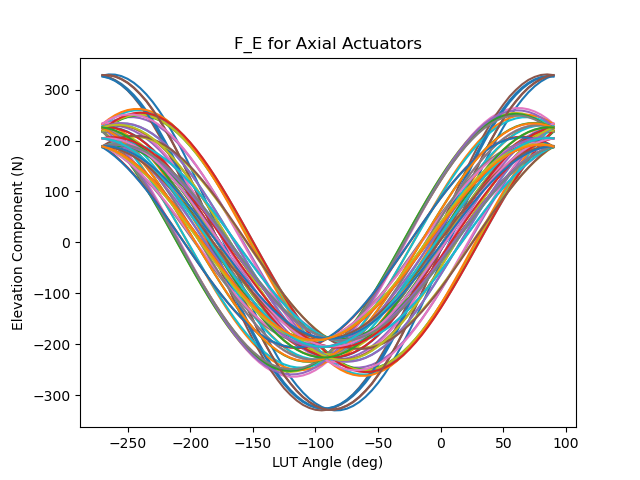

In [6]:
num_axial_acutator = NUM_ACTUATOR - NUM_TANGENT_LINK

plt.figure()
for idx in range(num_axial_acutator):
    plt.plot(
        control_closed_loop_surrogate._lut["lutInAngle"],
        control_closed_loop_surrogate._lut["F_E"][idx,:],
    )
plt.xlabel("LUT Angle (deg)")
plt.ylabel("Elevation Component (N)")
plt.title("F_E for Axial Actuators")
plt.show()

### 0g Component

**F_0** is a correction of error in the 0g shape of the mirror:

1. It is the difference between the minimum strain force set and the nominal force set.
2. Needs to be turned off for cart turnover.

- a. 0g forces need to be removed for turnover (negative weight + negative static correction -> high force magnitude).
- b. If simply switched off at horizon, actuator force would be discontinuous.
- c. Will be sinusoidally scaled to zero at nadir.
- d. For uniformity of control, interpolated from a table as are elevation components.
Constant 90 to 0 and -180 to -265.

3. Separated from **F_E** to facilitate the LUT updating (it may be of practical value to approximate the 0g shape of M2 in use).

0g forces are gradually reduced to 0 for cart turnover to create continuous force profile and low-stress mirror support.

Note: The update of LUT from FBS should be on the tables: **F_E** and **F_0**.

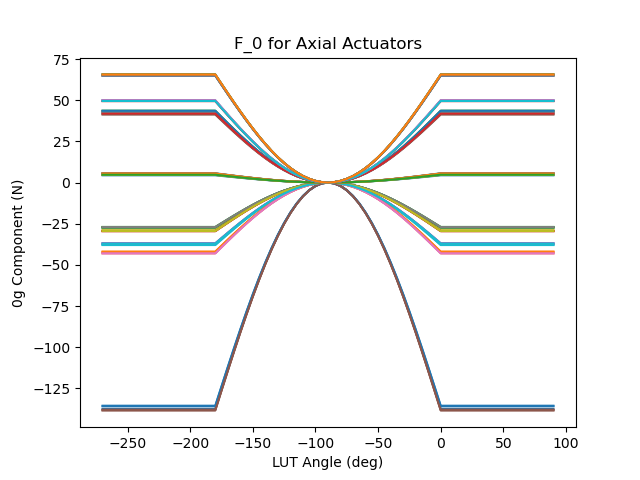

In [7]:
plt.figure()
for idx in range(num_axial_acutator):
    plt.plot(
        control_closed_loop_surrogate._lut["lutInAngle"],
        control_closed_loop_surrogate._lut["F_0"][idx,:],
    )
plt.xlabel("LUT Angle (deg)")
plt.ylabel("0g Component (N)")
plt.title("F_0 for Axial Actuators")
plt.show()

## Nominal Zenith Forces

Nominal zenith forces are the sum of the bare LUT value and the 0g correction forces.
This is based on the finite element analysis (FEA) to minize the strain of mirror.
Under the current scheme (or design), the single actuator of the inner ring (D ring) supports more weight compared with the actuator of the outer ring (ring B).

### Check the Nominal Forces at Zenith

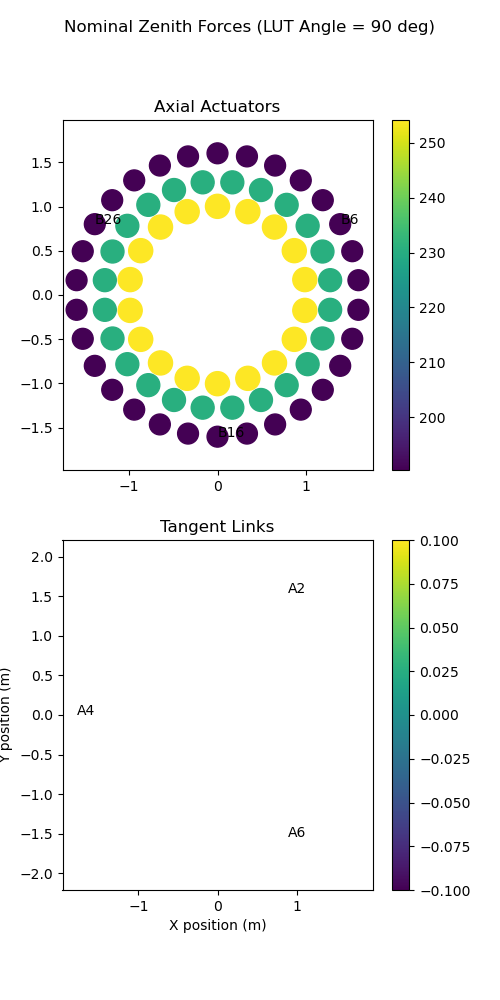

Total nominal force at zenith is 15818.356999999998 N.


In [8]:
force_nominal_zenith = (
    control_closed_loop_surrogate._lut["F_E"][:, -1] +
    control_closed_loop_surrogate._lut["F_0"][:, -1]
)
diagnostics_m2.draw_values(
    xy_actuators,
    force_nominal_zenith,
    np.zeros(NUM_TANGENT_LINK),
    title="Nominal Zenith Forces (LUT Angle = 90 deg)",
    hardpoints=hardpoints,
)

print(f"Total nominal force at zenith is {np.sum(force_nominal_zenith)} N.")

### Check the Nominal Forces at 45 Degree Elevation Angle

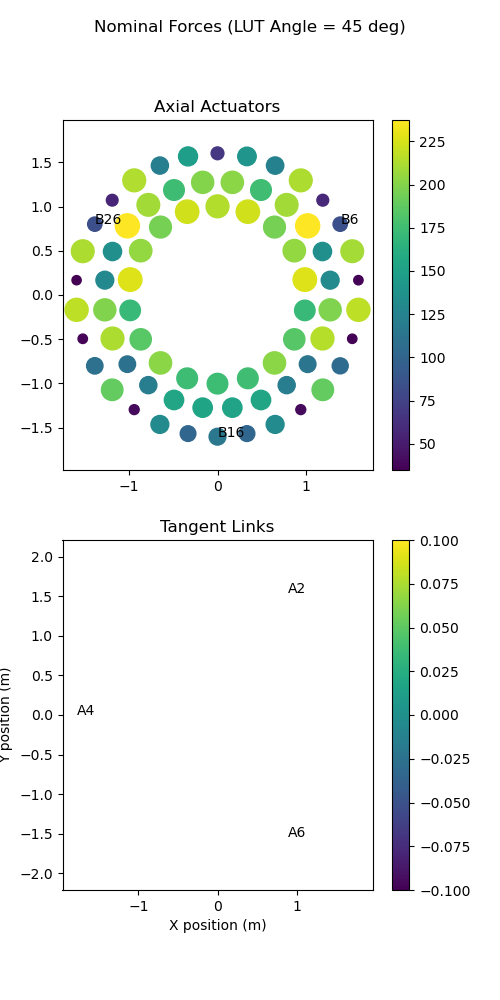

Total nominal force at 45 degree is 11187.3218 N.


In [9]:
index_45 = np.where(control_closed_loop_surrogate._lut["lutInAngle"] == 45)[0][0]
force_nominal_45 = (
    control_closed_loop_surrogate._lut["F_E"][:, index_45] +
    control_closed_loop_surrogate._lut["F_0"][:, index_45]
)

diagnostics_m2.draw_values(
    xy_actuators,
    force_nominal_45,
    np.zeros(NUM_TANGENT_LINK),
    title="Nominal Forces (LUT Angle = 45 deg)",
    hardpoints=hardpoints,
)

print(f"Total nominal force at 45 degree is {np.sum(force_nominal_45)} N.")

### Check the Normial Forces at Horizon

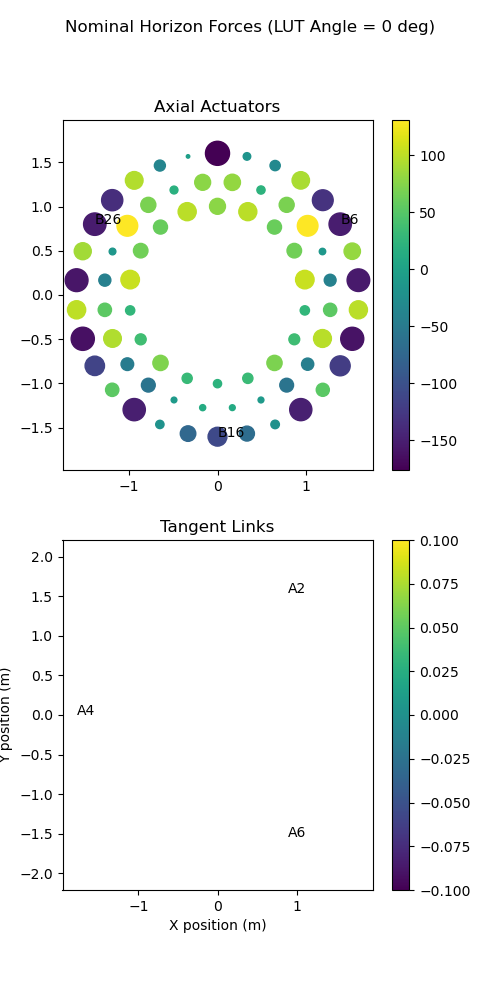

Total nominal force at horizon is 9.942600000000027 N.


In [10]:
index_horizon = np.where(control_closed_loop_surrogate._lut["lutInAngle"] == 0)[0][0]
force_nominal_horizon = (
    control_closed_loop_surrogate._lut["F_E"][:, index_horizon] +
    control_closed_loop_surrogate._lut["F_0"][:, index_horizon]
)

diagnostics_m2.draw_values(
    xy_actuators,
    force_nominal_horizon,
    np.zeros(NUM_TANGENT_LINK),
    title="Nominal Horizon Forces (LUT Angle = 0 deg)",
    hardpoints=hardpoints,
)

print(f"Total nominal force at horizon is {np.sum(force_nominal_horizon)} N.")

### Theoretical Moment X, Y based on the Nominal Forces

This gives the ideal net moment x and y of M2.

Note:
For the six tangent links (A1 - A6), only A2, A3, A5, and A6 will support the mirror's weight.
The force's direction of A2 and A3 is reversed to A5 and A6.
Therefore, the calculation of moment z should be 0 under the ideal orientation and assembly. 

In [11]:
moment_ideal_x = list()
moment_ideal_y = list()
for idx in range(len(control_closed_loop_surrogate._lut["lutInAngle"])):
    force_nominal = (
        control_closed_loop_surrogate._lut["F_E"][:, idx] +
        control_closed_loop_surrogate._lut["F_0"][:, idx]
    )
    moments = control_closed_loop_surrogate._calculate_xyz_net_moments(
        force_nominal, np.zeros(NUM_TANGENT_LINK))
    moment_ideal_x.append(moments["mx"])
    moment_ideal_y.append(moments["my"])

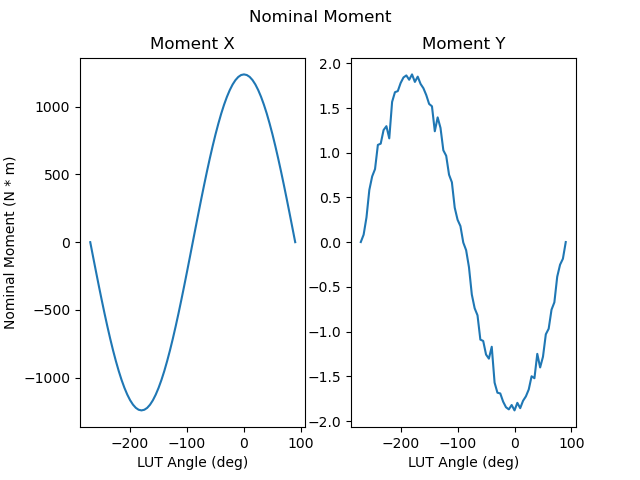

In [12]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(control_closed_loop_surrogate._lut["lutInAngle"], moment_ideal_x)
axs[1].plot(control_closed_loop_surrogate._lut["lutInAngle"], moment_ideal_y)

axs[0].set_ylabel("Nominal Moment (N * m)")

for ax in axs:
    ax.set_xlabel("LUT Angle (deg)")

axs[0].set_title("Moment X")
axs[1].set_title("Moment Y")

fig.suptitle("Nominal Moment")
plt.show()

We can see when the LUT angle is 0 degree, the moment-x is around 1238.28 N.
This balances with the moment from the mirror's weight with position of central gravity: 1588.65 kg * 9.8 m/s^2 * 3.1944 inch * 0.0254 m = 1263.22 N.

Note:

1. The value of 1588.65 kg comes from one of vendor's document that I forgot which one it is.
2. The value of 3.1944 inch comes from the **TangentTargetOffload.m** in **ts_mtm2_matlab_tools** repository. 

## Actuator Force Bias

**F_A** is established at the factory:

1. Corrects for self-weight readings of load cell (which change with elevation for the axial actuators).
2. Will be measured as part of the actuator setup.

**If any actuator on M2 is replaced by a spare actuator, this table needs to be updated to reflect the change of actuator.**

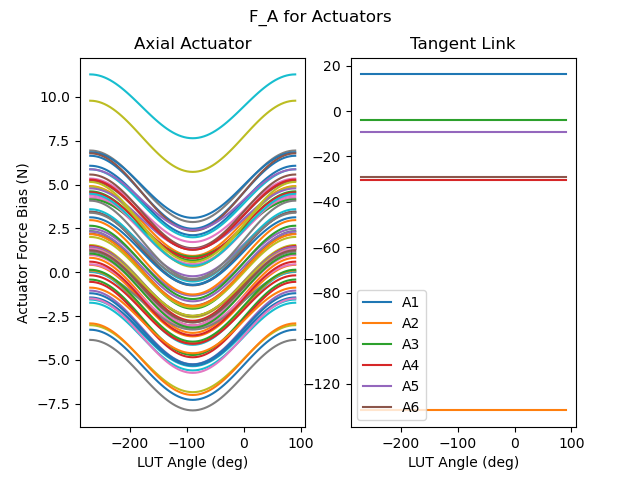

In [13]:
fig, axs = plt.subplots(1, 2)

for idx in range(NUM_ACTUATOR):
    ax = axs[0] if idx < num_axial_acutator else axs[1]
    ax.plot(
        control_closed_loop_mirror._lut["lutInAngle"],
        control_closed_loop_mirror._lut["F_A"][idx,:],
    )

axs[0].set_ylabel("Actuator Force Bias (N)")

for ax in axs:
    ax.set_xlabel("LUT Angle (deg)")
    
# Label the tangent links
axs[1].legend([f"A{idx + 1}" for idx in range(NUM_TANGENT_LINK)])

axs[0].set_title("Axial Actuator")
axs[1].set_title("Tangent Link")

fig.suptitle("F_A for Actuators")
plt.show()

### Factory Offset of Mirror

**F_F** is correction of residual fabrication error:

1. Like 0g error, this is a static term that is constant with elevation.
2. Different from 0g error in intent; 0g error is meant to exist, factory error is not.
3. Like 0g error, it must be gradually turned off as the mirror is inverted.
Also interpolated from a table.

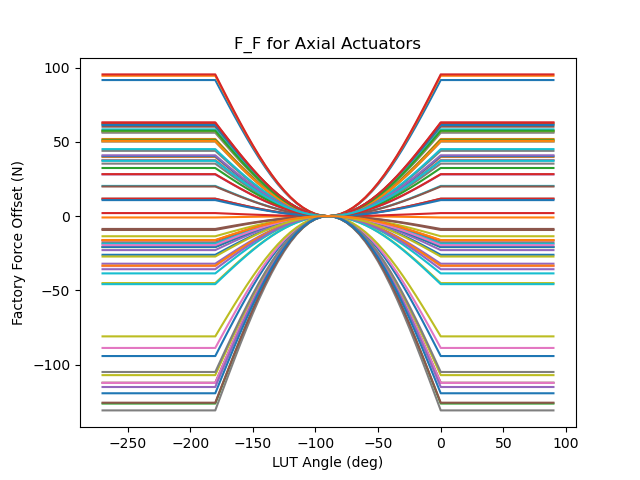

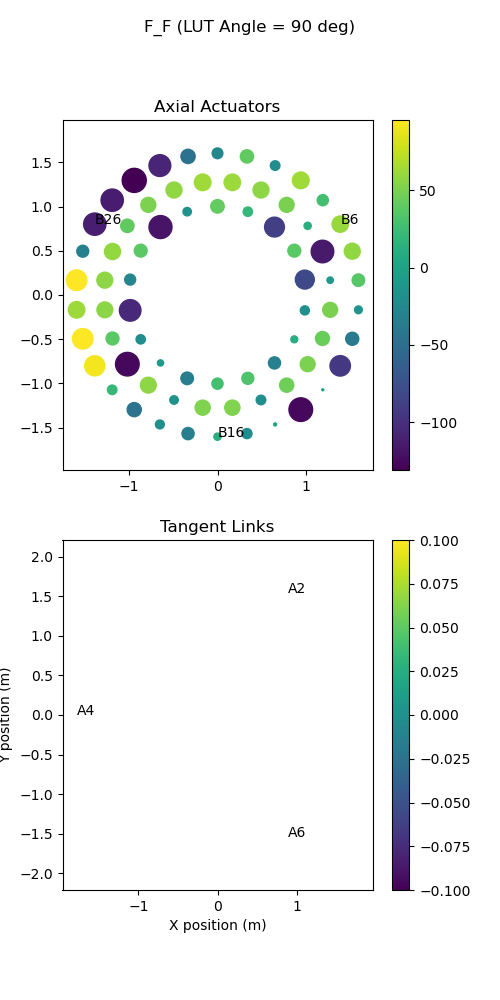

In [14]:
plt.figure()
for idx in range(num_axial_acutator):
    plt.plot(
        control_closed_loop_mirror._lut["lutInAngle"],
        control_closed_loop_mirror._lut["F_F"][idx,:],
    )
plt.xlabel("LUT Angle (deg)")
plt.ylabel("Factory Force Offset (N)")
plt.title("F_F for Axial Actuators")
plt.show()

diagnostics_m2.draw_values(
    xy_actuators,
    control_closed_loop_mirror._lut["F_F"][:, -1],
    np.zeros(NUM_TANGENT_LINK),
    title="F_F (LUT Angle = 90 deg)",
    hardpoints=hardpoints,
)

### Theoretical Moment for the Mirror's LUT

Calculate the theoretical moment based on LUT of mirror.
The measured value should be closed to this theoretical limits if:

1. M2 has the ideal orientation and assembly.
2. FBS works well.

In the following simulation, we can see:

1. At the horizon, the moment x has the value of 1253.86 N * m, which is closed to the 1263.22 N * m calculated above.
2. The moment z is a constant.

In [15]:
moment_ideal_mirror_x = list()
moment_ideal_mirror_y = list()
moment_ideal_mirror_z = list()
for idx in range(len(control_closed_loop_mirror._lut["lutInAngle"])):
    force_nominal_mirror_axial = (
        control_closed_loop_mirror._lut["F_E"][:, idx] +
        control_closed_loop_mirror._lut["F_0"][:, idx] +
        control_closed_loop_mirror._lut["F_A"][:num_axial_acutator, idx] +
        control_closed_loop_mirror._lut["F_F"][:, idx]
    )
    force_nominal_mirror_tangent = control_closed_loop_mirror._lut["F_A"][
        num_axial_acutator:, idx]

    moments = control_closed_loop_mirror._calculate_xyz_net_moments(
        force_nominal_mirror_axial, force_nominal_mirror_tangent)
    moment_ideal_mirror_x.append(moments["mx"])
    moment_ideal_mirror_y.append(moments["my"])
    moment_ideal_mirror_z.append(moments["mz"])

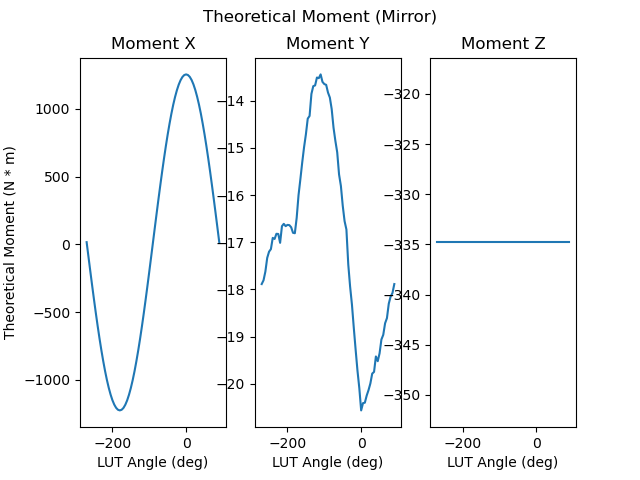

In [16]:
fig, axs = plt.subplots(1, 3)

for idx, moment in enumerate(
    [moment_ideal_mirror_x, moment_ideal_mirror_y, moment_ideal_mirror_z]
):
    axs[idx].plot(control_closed_loop_mirror._lut["lutInAngle"], moment)

axs[0].set_ylabel("Theoretical Moment (N * m)")

for ax in axs:
    ax.set_xlabel("LUT Angle (deg)")

for idx, axis in enumerate(["X", "Y", "Z"]):
    axs[idx].set_title(f"Moment {axis}")

fig.suptitle("Theoretical Moment (Mirror)")
plt.show()

## Force Balance System (FBS)

This is the correction of hardpoint force balance error:

1. Due to wind, inertial loads, and measurement/control error.
2. Three hardpoint errors define a force plane that resolves to bias and tilt.
3. All 72 actuators are fit to this plane.
Hardpoints carry their share of external disturbances.

The calculation happens at **controlLoop.lvlib: Control Loop (FIFO).vi** under the **ts_mtm2_cell** repository.
It contains the forward (or feed foward) and backward (or feedback) modeling.
At this moment, only the backward part is reverse-engineered to Python code to support the simulation.
See the **MockControlClosedLoop.calc_hp_comp_matrix()** in the **ts_m2com** repository for more details.

The idea is to make the moment-x amd moment-y keep the same when distributes the force of axial hardpoints to other axial actuators.
It is the same idea for tangential actuators with moment-z.
This calculation depends on the LUT calculation (which depends on the elevation angle such as **F_E**) and measured force.
Therefore, it is not strange to see the dependency between the hardpoint correction and elevation angle.
See the **MockControlClosedLoop._calc_look_up_forces_hardpoint()** for more details.

### Rotate the Cart at Level 3

Rotate the M2 cart at level 3 to have the full range data of 0-90 degree.
The processed inclinometer angle should have the same coordinate of TMA at this range, which is used in the LUT calculation.

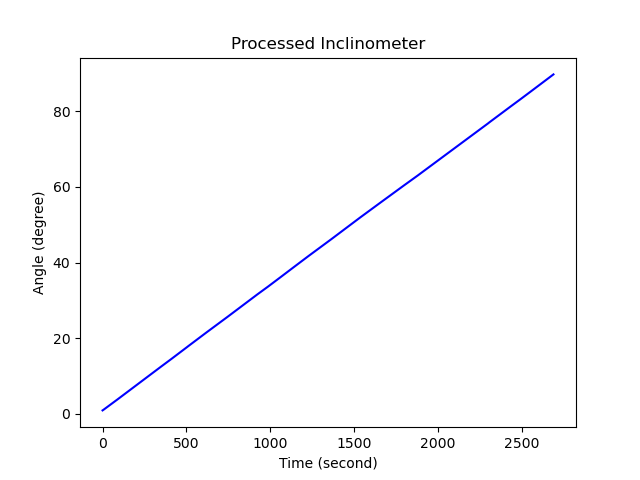

In [17]:
time_start = Time("2023-08-03T02:00:00", scale="utc", format="isot")
time_end = Time("2023-08-03T02:45:00", scale="utc", format="isot")

data_zenith_angle, time_operation_angle = await diagnostics_m2.get_data_zenith_angle(
    time_start, time_end
)
diagnostics_m2.plot_processed_inclinometer(
    data_zenith_angle, time_operation_angle
)

We can see the hardpoints are passive actuators to support the M2's position only (delta step is 0).

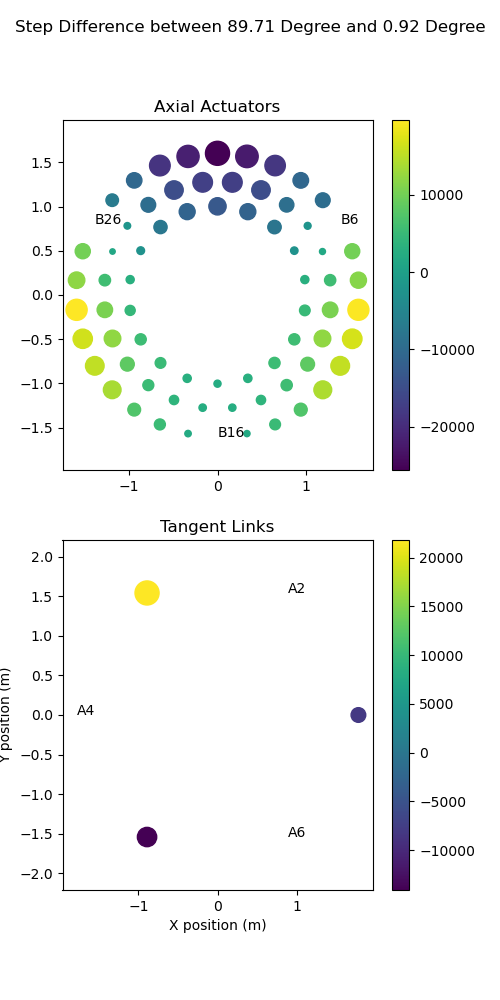

In [18]:
data_step_axial, time_operation_axial = await diagnostics_m2.get_data_step_axial(
    time_start, time_end)
data_step_tangent, time_operation_tangent = await diagnostics_m2.get_data_step_tangent(
    time_start, time_end)

angle_start = data_zenith_angle.inclinometerProcessed[0]
angle_end = data_zenith_angle.inclinometerProcessed[-1]
diagnostics_m2.draw_values(
    xy_actuators,
    data_step_axial[-1,:]-data_step_axial[0,:],
    data_step_tangent[-1,:]- data_step_tangent[0,:],
    title=f"Step Difference between {angle_end} Degree and {angle_start} Degree",
    hardpoints=hardpoints,
)

However, the measured forces of hardpoints may not be closed to 0, which depends on the orientation of M2.

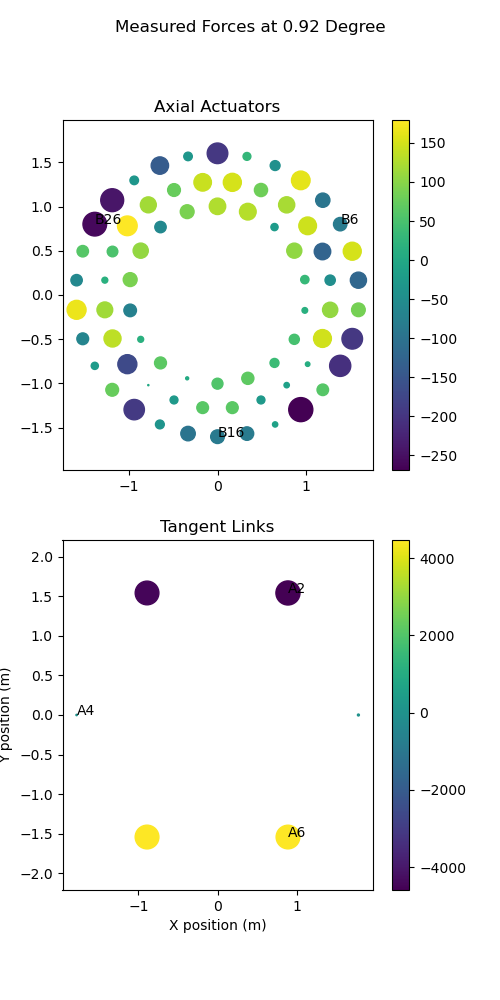

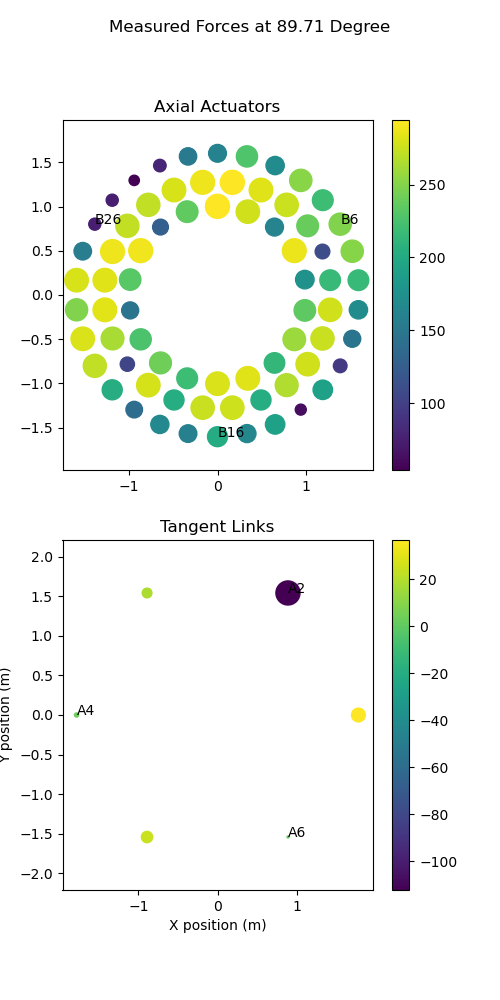

In [19]:
data_collected_axial, data_collected_tangent = await diagnostics_m2.get_data_force(
    time_start, time_end
)
diagnostics_m2.draw_values(
    xy_actuators,
    data_collected_axial["measured"][0,:],
    data_collected_tangent["measured"][0,:],
    title=f"Measured Forces at {angle_start} Degree",
    hardpoints=hardpoints,
)
diagnostics_m2.draw_values(
    xy_actuators,
    data_collected_axial["measured"][-1,:],
    data_collected_tangent["measured"][-1,:],
    title=f"Measured Forces at {angle_end} Degree",
    hardpoints=hardpoints,
)

Check the force balance correction at zenith and horizon in the following figures.

At the horizon, the magnitude of hardpoint correction is around 1.5 N for axial actuators.
However, the related value for tangent link is around 4000 N.
This is expected because the tangent links need to support the mirror's weight at horizon.

At the zenith, the magnitude of hardpoint correction is less than 7 N for axial actuators and 35 N for tangent links.

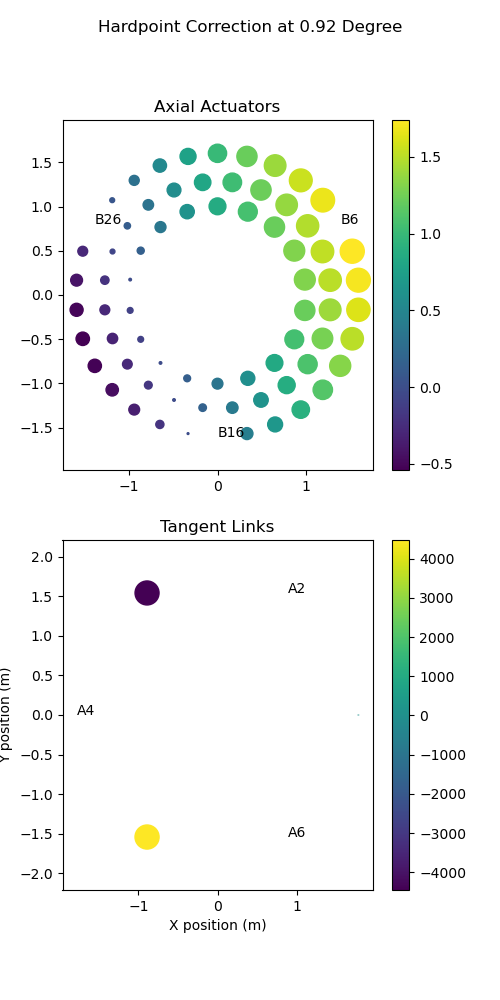

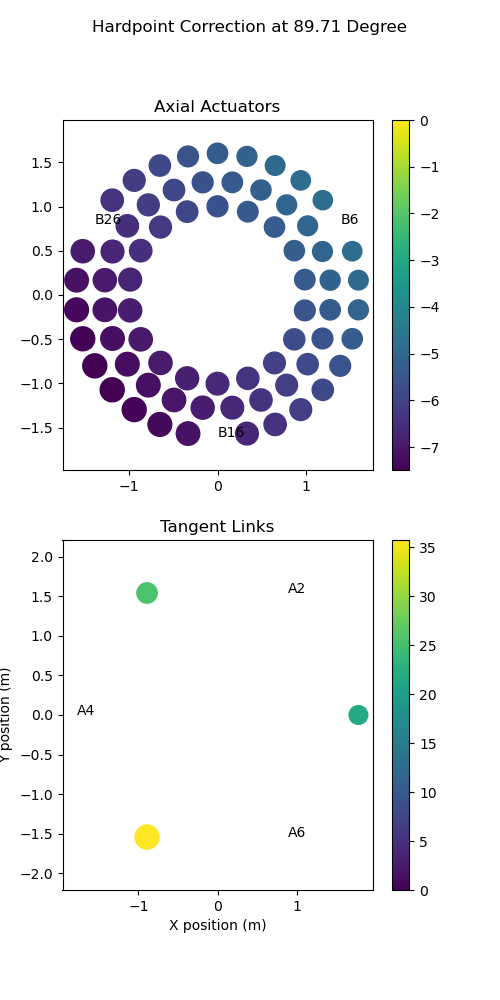

In [20]:
# In the backward modeling, the hardpoint correction of hardpoints is 0 actually.
# But to be honest, I do not really understand this part, which comes from the code
# in ts_mtm2 (M2 LabVIEW EUI).
data_collected_axial["hardpointCorrection"][:, hardpoints[:NUM_HARDPOINTS_AXIAL]] = 0

tangent_hardpoints = [(idx - num_axial_acutator) for idx in hardpoints[NUM_HARDPOINTS_AXIAL:]]
data_collected_tangent["hardpointCorrection"][:, tangent_hardpoints] = 0

diagnostics_m2.draw_values(
    xy_actuators,
    data_collected_axial["hardpointCorrection"][0,:],
    data_collected_tangent["hardpointCorrection"][0,:],
    title=f"Hardpoint Correction at {angle_start} Degree",
    hardpoints=hardpoints,
)
diagnostics_m2.draw_values(
    xy_actuators,
    data_collected_axial["hardpointCorrection"][-1,:],
    data_collected_tangent["hardpointCorrection"][-1,:],
    title=f"Hardpoint Correction at {angle_end} Degree",
    hardpoints=hardpoints,
)

Compare the measured moments and theoretical values in the following.

There are 3 factors to decide the difference:

1. M2 has the ideal orientation or not.
2. M2 has the ideal assembly or not.
3. FBS works correctly or not.

Note:
The queried data contains the LUT temperature correction (which is very small), and we need to remove this part first before the comparison.

In [21]:
# Query the data in EFD and remove the affection from the temperature LUT
data_moment, time_operation_moment = await diagnostics_m2.get_data_net_moment(
    time_start, time_end, realign_time=False,
)

# Interpolate the temperature correction of axial actuators
num_data = len(data_moment.private_sndStamp)
correction_axial_interp = np.zeros((num_data, num_axial_acutator))

for idx in range(num_axial_acutator):
    single_axial_interp = np.interp(
        data_moment.private_sndStamp,
        data_collected_axial["timestamp"],
        data_collected_axial["lutTemperature"][:, idx],
    )
    correction_axial_interp[:, idx] = single_axial_interp

moment_temperature = dict(mx=np.zeros(num_data), my=np.zeros(num_data), mz=np.zeros(num_data))
for idx in range(num_data):
    moment = control_closed_loop_mirror._calculate_xyz_net_moments(
        correction_axial_interp[idx, :],
        np.zeros(NUM_TANGENT_LINK),
    )
    for axis in (moment.keys()):
        moment_temperature[axis][idx] = moment[axis]

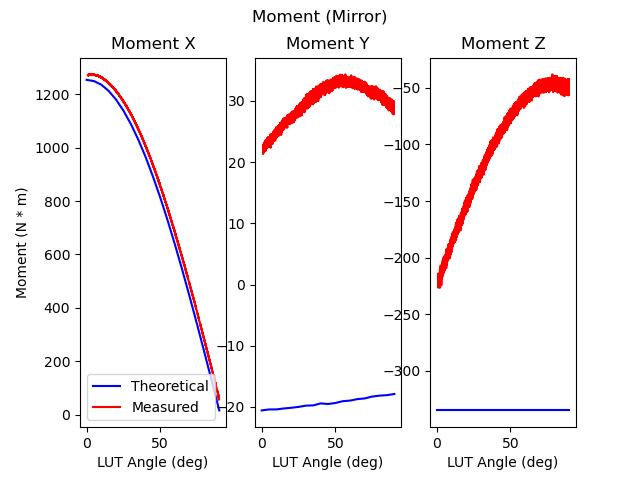

In [22]:
# Realign the timestamp
time_operation_moment = time_operation_moment - time_operation_moment[0]

fig, axs = plt.subplots(1, 3)

# Plot the theoretical values first
idx_0 = np.where(control_closed_loop_mirror._lut["lutInAngle"] == 0)[0][0]
for idx, moment in enumerate(
    [moment_ideal_mirror_x, moment_ideal_mirror_y, moment_ideal_mirror_z]
):
    axs[idx].plot(
        control_closed_loop_mirror._lut["lutInAngle"][idx_0:],
        moment[idx_0:],
        "b",
    )

# Plot the measured values
lut_angles = np.interp(
    time_operation_moment,
    time_operation_angle,
    data_zenith_angle.inclinometerProcessed,
)
for idx, axis in enumerate(["mx", "my", "mz"]):
    axs[idx].plot(lut_angles, getattr(data_moment, axis) - moment_temperature[axis], "r")
    
axs[0].legend(["Theoretical", "Measured"])
axs[0].set_ylabel("Moment (N * m)")

for ax in axs:
    ax.set_xlabel("LUT Angle (deg)")

for idx, axis in enumerate(["X", "Y", "Z"]):
    axs[idx].set_title(f"Moment {axis}")

fig.suptitle("Moment (Mirror)")
plt.show()

Assume the affection of non-ideal orientation and assembly is just a constant change to moments.
To be honest, I do not know this is correct or not.
I do this just based on my bad intuition.

In [23]:
constants = list()
for axis, moment in zip(
    ["mx", "my", "mz"],
    [moment_ideal_mirror_x, moment_ideal_mirror_y, moment_ideal_mirror_z],
):
    constant = diff_value_avg(
        lut_angles,
        getattr(data_moment, axis) - moment_temperature[axis],
        control_closed_loop_mirror._lut["lutInAngle"][idx_0:],
        moment[idx_0:],
    )
    constants.append(constant)

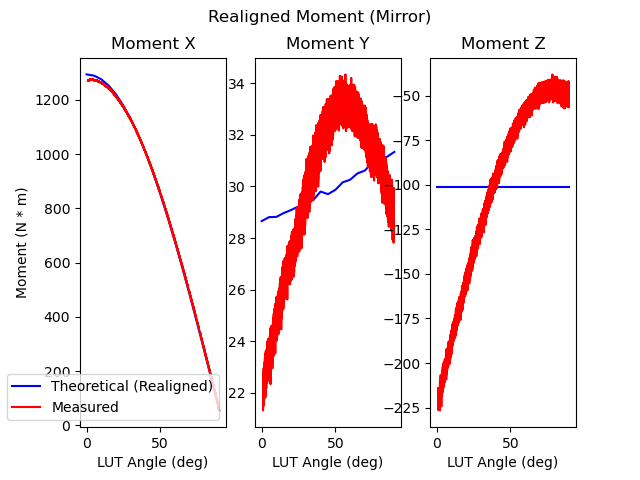

In [24]:
fig, axs = plt.subplots(1, 3)

# Plot the realigned theoretical values first
idx_0 = np.where(control_closed_loop_mirror._lut["lutInAngle"] == 0)[0][0]
for idx, moment in enumerate(
    [moment_ideal_mirror_x, moment_ideal_mirror_y, moment_ideal_mirror_z]
):
    axs[idx].plot(
        control_closed_loop_mirror._lut["lutInAngle"][idx_0:],
        moment[idx_0:] + constants[idx],
        "b",
    )

# Plot the measured values
for idx, axis in enumerate(["mx", "my", "mz"]):
    axs[idx].plot(lut_angles, getattr(data_moment, axis) - moment_temperature[axis], "r")
    
axs[0].legend(["Theoretical (Realigned)", "Measured"])
axs[0].set_ylabel("Moment (N * m)")

for ax in axs:
    ax.set_xlabel("LUT Angle (deg)")

for idx, axis in enumerate(["X", "Y", "Z"]):
    axs[idx].set_title(f"Moment {axis}")

fig.suptitle("Realigned Moment (Mirror)")
plt.show()

I do not think the above fitting is correct after doing the comparion except the moment x.
There should be a way to model the non-ideal orientation and assembly to show the dependency between the moment (y, z) and the LUT angle range.

The moment z ($m_{z}$) is the value of mirror's radius times the tangential forces.
Alougth theoretically the forces of A2 and A3 should cancel out the forces of A5 and A6 thoroughly, this might not be true and there would be some force residue, $f_{r}$, left in this process ($c$ and $\theta_{c}$ are constants, and ${r}$ is the radius of mirror):

$$ m_{z} = c + f_{r} * r \sin(\theta - \theta_{c}).$$

The non-zero $f_{r}$ and $\theta_{c}$ reflect the non-ideal orientation and assembly.
The difference between constant $c$ and the theoretical constant moment z reflects the affection of FBS. 

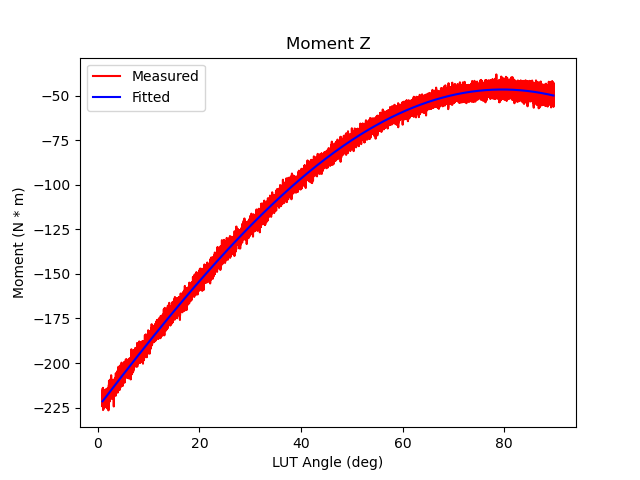

Fitted constant is -264.1965350700074 N*m.


In [25]:
# Fit the moment z as the following
res = optimize.minimize(
    fit_moment_z,
    np.array([-200, 80, 10]),
    args=(
        lut_angles,
        np.array(data_moment.mz) - moment_temperature["mz"],
        control_closed_loop_mirror.get_radius(),
    ),
)

plt.figure()
plt.plot(lut_angles, data_moment.mz - moment_temperature["mz"], "r")
plt.plot(
    lut_angles,
    res.x[0] + res.x[1] * control_closed_loop_mirror.get_radius() * np.sin(np.deg2rad(lut_angles - res.x[2])),
    "b",
)
plt.legend(["Measured", "Fitted"])

plt.xlabel("LUT Angle (deg)")
plt.ylabel("Moment (N * m)")

plt.title("Moment Z")

plt.show()

print(f"Fitted constant is {res.x[0]} N*m.")

For the measured moment y, it is a complex question and I do not have a good idea to explain it at this moment. 

In [ ]:
plt.close("all")